Jeremy is interested in seeing the occupation at fixed mass as a func of concentration, and what, if any parameterization is a good fit. 

In [1]:
import numpy as np
from scipy.stats import binned_statistic
from pearce.mocks import compute_prim_haloprop_bins
from halotools.utils.table_utils import compute_conditional_percentiles

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
sns.set_palette(sns.diverging_palette(255, 133, l=60, n=22, center="dark"))
colors = cycle(sns.color_palette())

In [3]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048
#catalog = np.loadtxt('sham_hod_data_cut.npy')

from astropy.table import Table
halo_catalog = Table.read('abmatched_halos.hdf5', format = 'hdf5')

In [4]:
halo_catalog.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_vpeak_mag',
 'halo_vvir_mag',
 'halo_alpha_05_mag',
 'halo_shuffled_vpeak_mag',
 'halo_shuffled_vvir_mag',
 'halo_shuffled_alpha_05_mag',
 'host_halo_nfw_conc',
 'host_halo_rvir',
 'halo_nfw_x',
 'halo_nfw_y',
 'halo_nfw_z',
 'halo_sh_shuffled_vpeak_mag',
 'halo_sh_shuffled_vvir_mag',
 'halo_sh_shuffled_alpha_05_mag',
 'halo_shuffled_x',
 'halo_shuffled_y',
 'halo_shuffled_z',
 'halo_shuffled_upid',
 'halo_shuffled_host_mvir',
 'halo_sh_shuffled_x',
 'halo_sh_shuffled_y',
 'halo_sh_shuffled_z',
 'halo_sh_shuffled_upid',
 'halo_sh_shuffled_host_mvir',
 'halo_sh_shuffled_cen_vpeak_mag',
 'halo_sh_shuffled_cen_vvir_mag',
 'halo_sh_shuffled_cen_alpha_05_mag',
 'halo_sh_shuffled_cen_x',
 'halo_sh_shuffled_cen_y',
 'halo_sh_shuffled_cen_z',
 'halo_sh_shuffled_c

In [5]:
mag_key = 'halo_vpeak_mag'
upid_key = 'halo_upid'

In [6]:
from collections import Counter
def compute_occupations(halo_table, halo_catalog):
    #halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]

    cens_occ = np.zeros((np.sum(halo_table['halo_upid'] == -1),))
    #cens_occ = np.zeros((len(halo_table),))
    sats_occ = np.zeros_like(cens_occ)
    detected_central_ids = set(halo_catalog[halo_catalog[upid_key]==-1]['halo_id'])
    detected_satellite_upids = Counter(halo_catalog[halo_catalog[upid_key]!=-1][upid_key])

    for idx, row  in enumerate(halo_table[halo_table['halo_upid'] == -1]):
        cens_occ[idx] = 1.0 if row['halo_id'] in detected_central_ids else 0.0
        sats_occ[idx]+= detected_satellite_upids[row['halo_id']]

    return cens_occ, sats_occ

In [7]:
mag_cut = -21
min_ptcl = 200
from pearce.mocks import cat_dict
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)
halo_masses = cat.halocat.halo_table['halo_mvir']
#halo_table = halo_catalog#cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]
halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]
halo_catalog = halo_catalog[np.logical_and(halo_catalog['halo_mvir'] > min_ptcl*cat.pmass, \
                                          halo_catalog[mag_key] < mag_cut )]
cens_occ, sats_occ = compute_occupations(halo_table, halo_catalog)

In [8]:
nfw_conc= (halo_table['halo_rvir']/halo_table['halo_rs'])[halo_table['halo_upid']==-1]
klypin_conc = (halo_table['halo_rvir']/halo_table['halo_rs_klypin'])[halo_table['halo_upid']==-1]

In [9]:
catalog = np.zeros((np.sum(halo_table['halo_upid']==-1), 6))
#catalog[:,3] = halo_table[halo_table[upid_key]==-1]['halo_mvir']
catalog[:,3] = halo_table[halo_table['halo_upid']==-1]['halo_mvir']
catalog[:,1] = cens_occ
catalog[:,2] = sats_occ
catalog[:,5] = halo_table[halo_table['halo_upid']==-1]['halo_vpeak']#['halo_nfw_conc']

In [10]:
from math import ceil
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.05):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [11]:
mass_bins = compute_mass_bins(catalog[:,3], 0.2)
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0
print mass_bins.shape

(22,)


In [12]:
mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = catalog[:,3])

In [13]:
conc_bins = np.linspace(0, 1000, 10)#np.linspace(0, 1000, 10)#np.linspace(0, 22, 10)

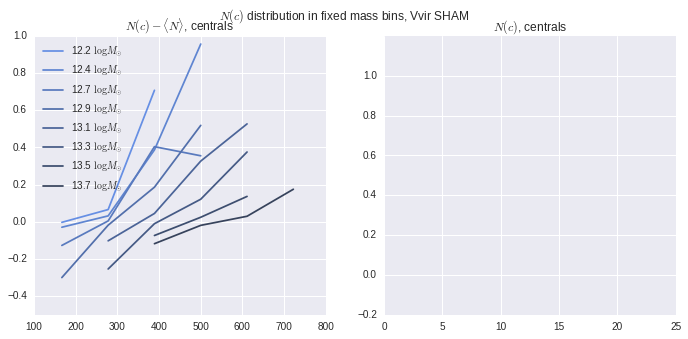

In [14]:
mass_bin_nos = range(5,13,1)
fig = plt.figure(figsize = ((11.5,5)))
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])
    
    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
    
    cen_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,1], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(c_bin_centers,(binned_cens-cens_avg),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)
    plt.plot(c_bin_centers,(binned_cens),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.legend(loc='best')
#plt.xlim([0,25])
plt.ylim([-0.5,1.0])
plt.subplot(122)
plt.title(r"$N(c)$, centrals")
#plt.yscale('log')
#plt.xscale('log')
plt.ylim([-0.2,1.2])
plt.xlim([0,25])
plt.suptitle(r"$N(c)$ distribution in fixed mass bins, Vvir SHAM")
plt.show()

In [15]:
import cPickle as pickle
with open('cen_nc_occ.pkl','r') as f:
    hod_data = pickle.load(f)

In [16]:
sns.set_palette(sns.diverging_palette(255, 133, l=60, n=20, center="dark"))
colors = sns.color_palette()

142.0 2.0 0.000882288980708
776.0 1.0 0.00732393302754
3077.0 2.0 0.0443129122383
6613.0 30.0 0.145079197929
8703.0 133.0 0.299752014879


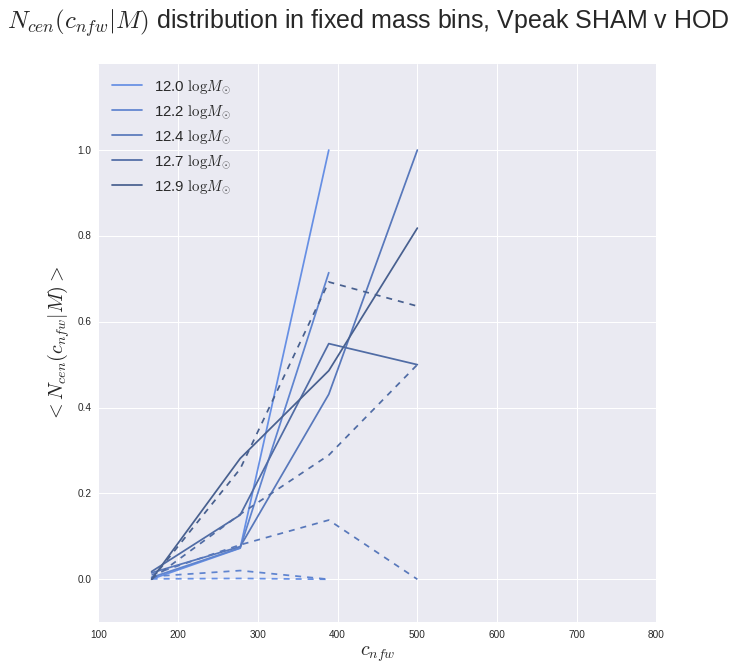

In [17]:
mass_bin_nos = range(1,15,1)
fig = plt.figure(figsize = ((10,10)))
color_idx=0
for bin_no, (hod_cbc, hod_occ) in zip(mass_bin_nos, hod_data):
    if bin_no < 4 or bin_no >8:
        continue
    c = colors[color_idx]
    color_idx+=1
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])
    
    print np.sum(catalog[indices_of_mb,1]),np.sum(catalog[indices_of_mb,2]), cens_avg
        
    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
    
    cen_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,1], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    #plt.plot(c_bin_centers,(binned_cens-cens_avg),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    #plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)
    plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(hod_cbc,hod_occ,color = c,ls = '--')

    #plt.vlines(med_conc, -1, 1, color = c)
    #plt.hist(catalog[indices_of_mb, 5], bins = 10, alpha = 0.3, color = c, normed=True)
    
    
#plt.subplot(121)
#plt.xscale('log')
#plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.legend(loc='best', fontsize = 15)
#plt.xlim([0,25])
#plt.ylim([-0.5,1.0])
#plt.subplot(122)
#plt.title(r"$N(c)$, centrals")
#plt.yscale('log')
#plt.xscale('log')
plt.ylim([-0.1,1.2])
#plt.xlim([0,25])
plt.suptitle(r"$N_{cen}(c_{nfw}|M)$ distribution in fixed mass bins, Vpeak SHAM v HOD", fontsize = 25)
plt.xlabel(r"$c_{nfw}$", fontsize =20)
plt.ylabel(r"$<N_{cen}(c_{nfw}|M)>$", fontsize=20)
plt.show()

In [18]:
from scipy.stats import linregress

6.0 0.0 1.07512238476e-05


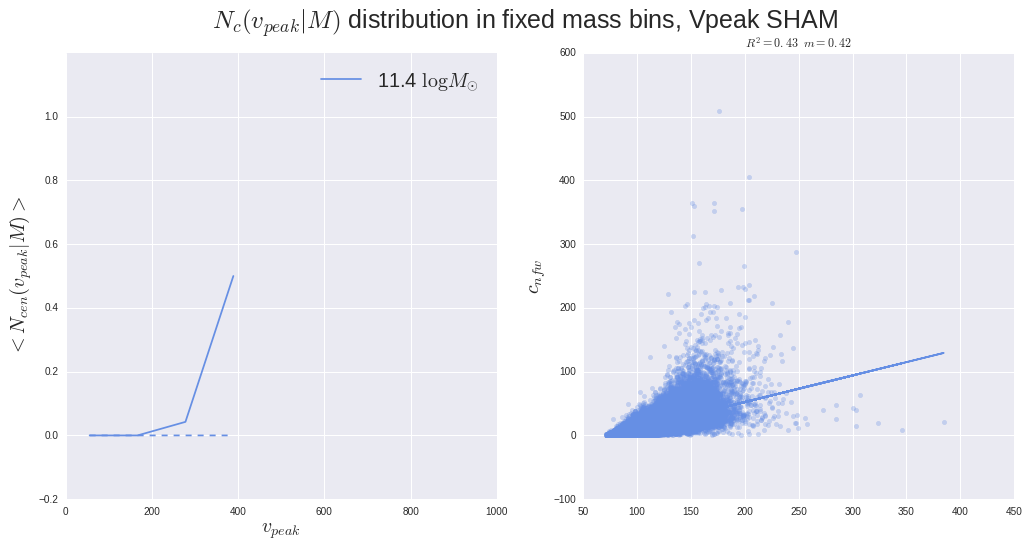

23.0 0.0 6.25538847322e-05


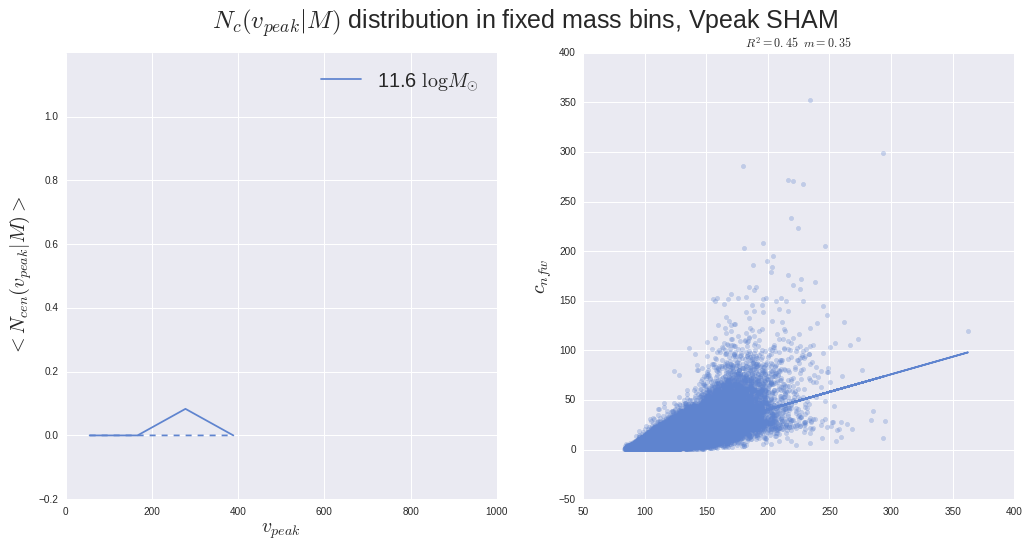

62.0 0.0 0.000254792775392


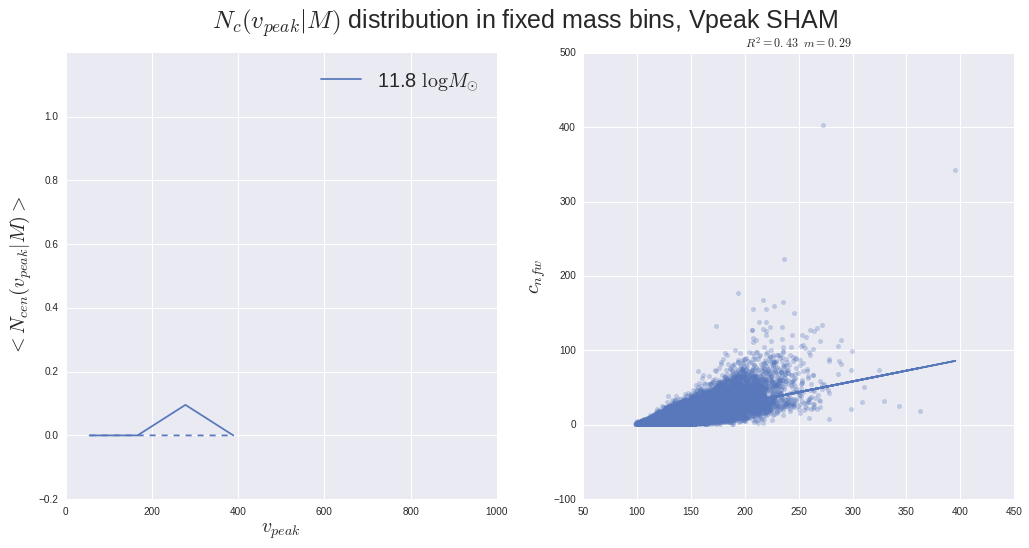

142.0 2.0 0.000882288980708


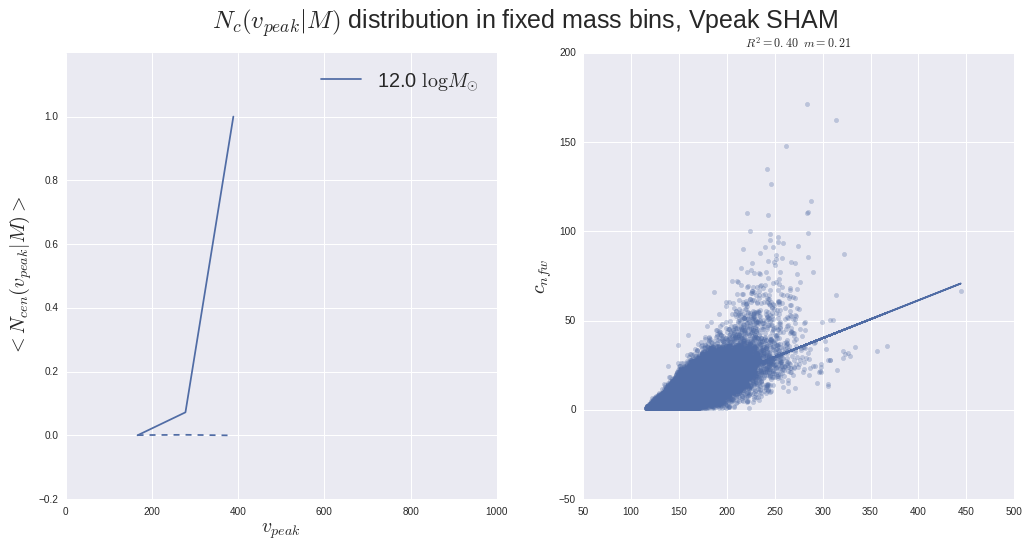

776.0 1.0 0.00732393302754


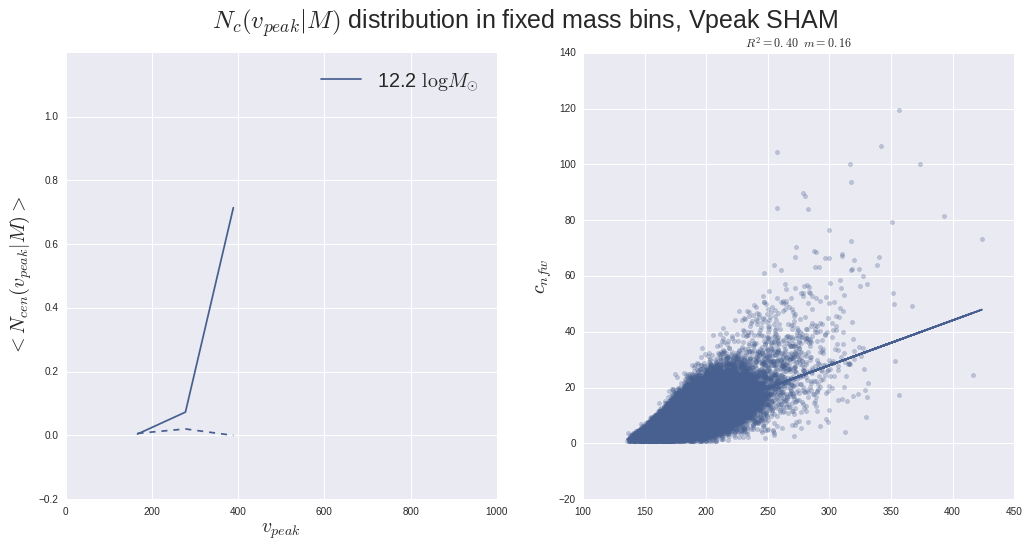

3077.0 2.0 0.0443129122383


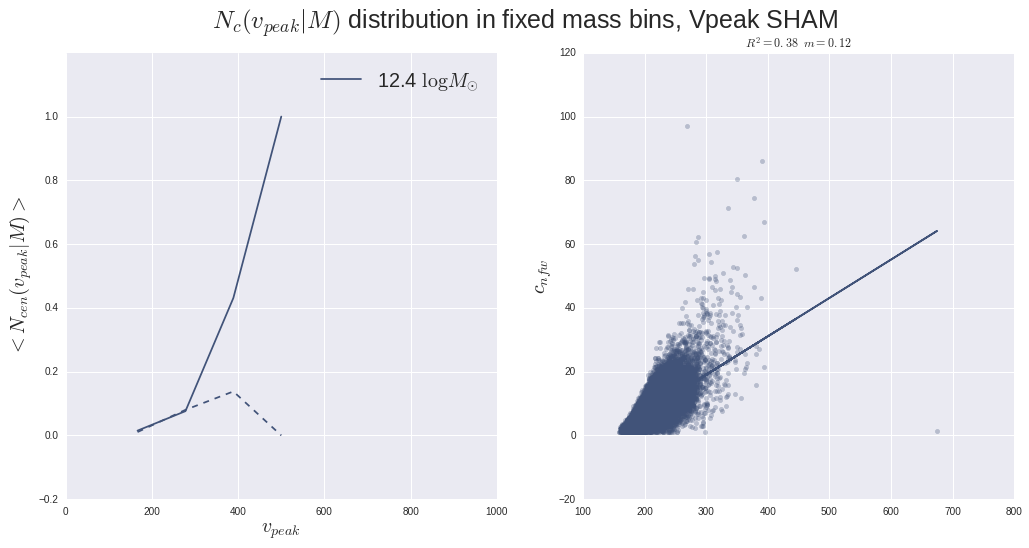

6613.0 30.0 0.145079197929


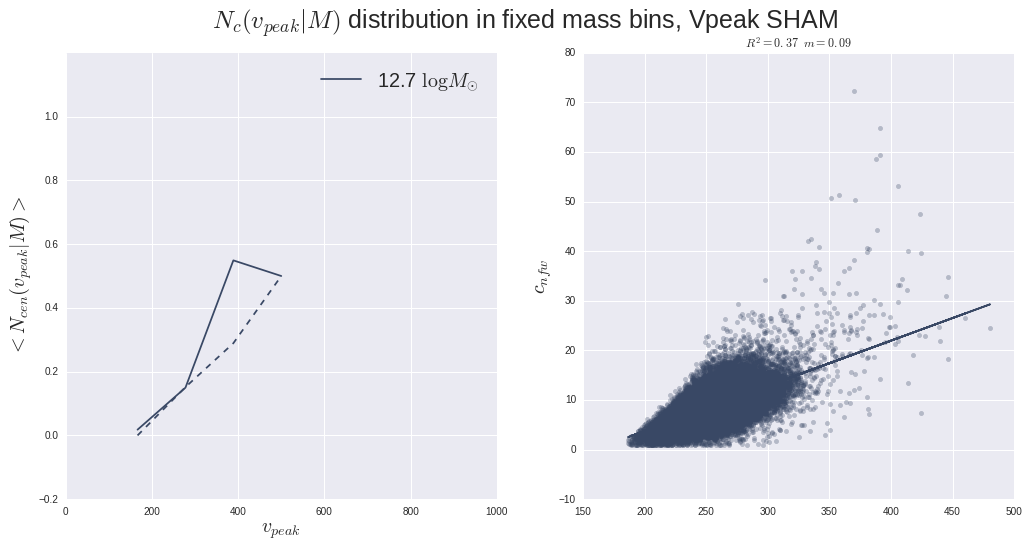

8703.0 133.0 0.299752014879


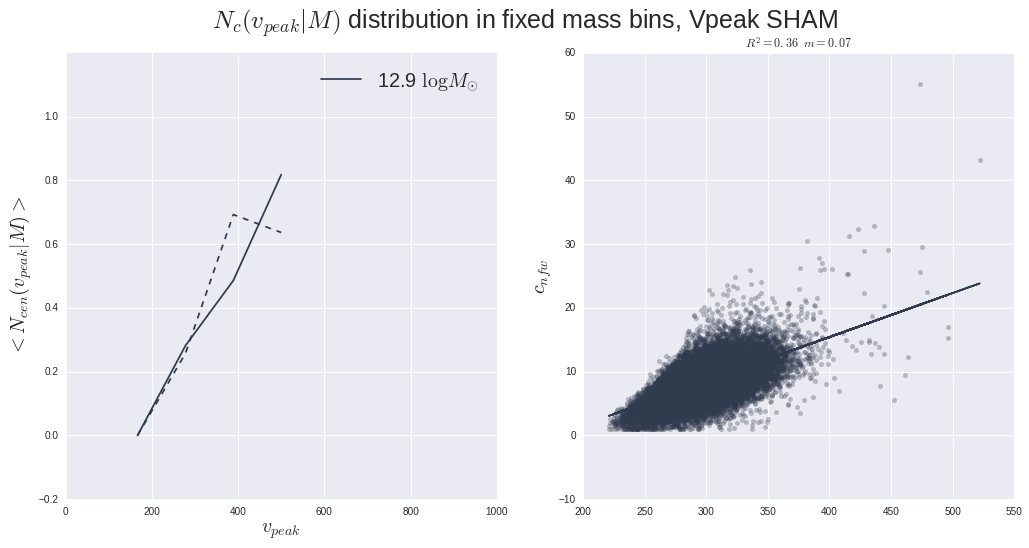

8823.0 367.0 0.473590982287


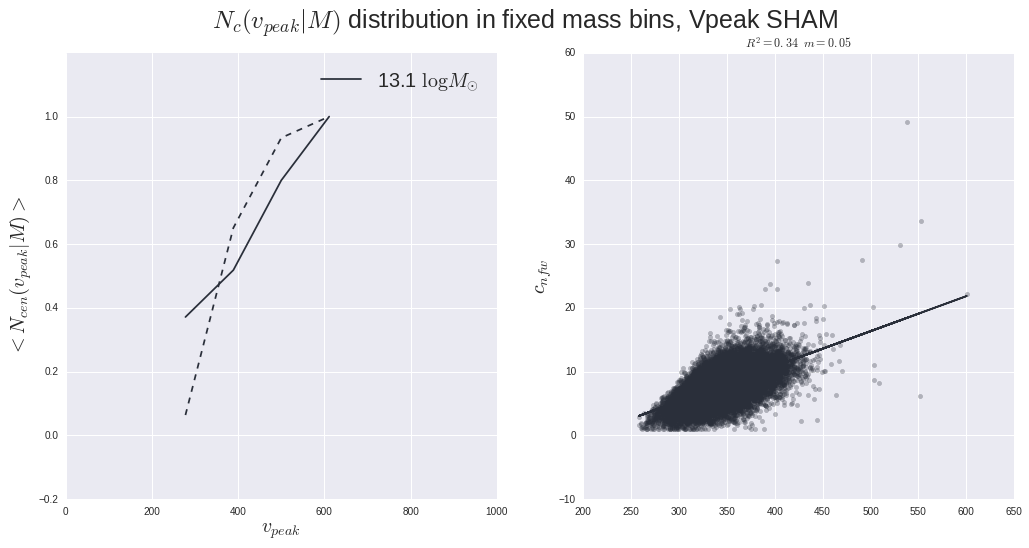

7466.0 631.0 0.62482216085


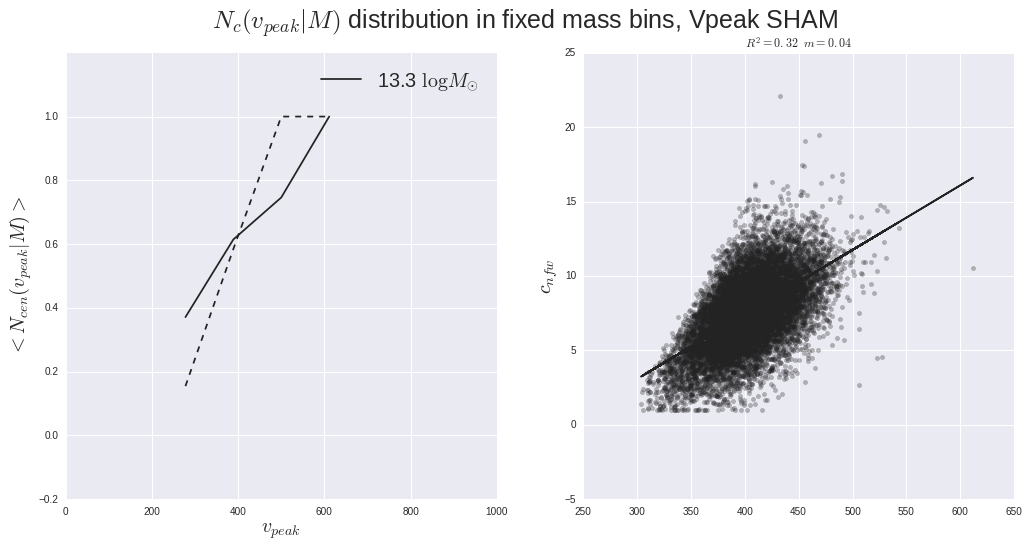

5525.0 999.0 0.734805160261


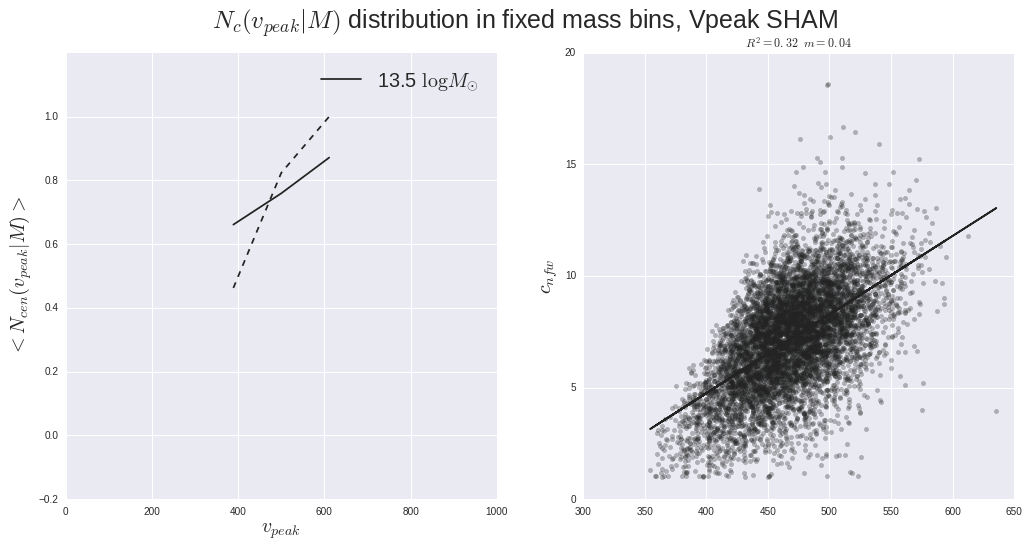

3866.0 1196.0 0.825010670081


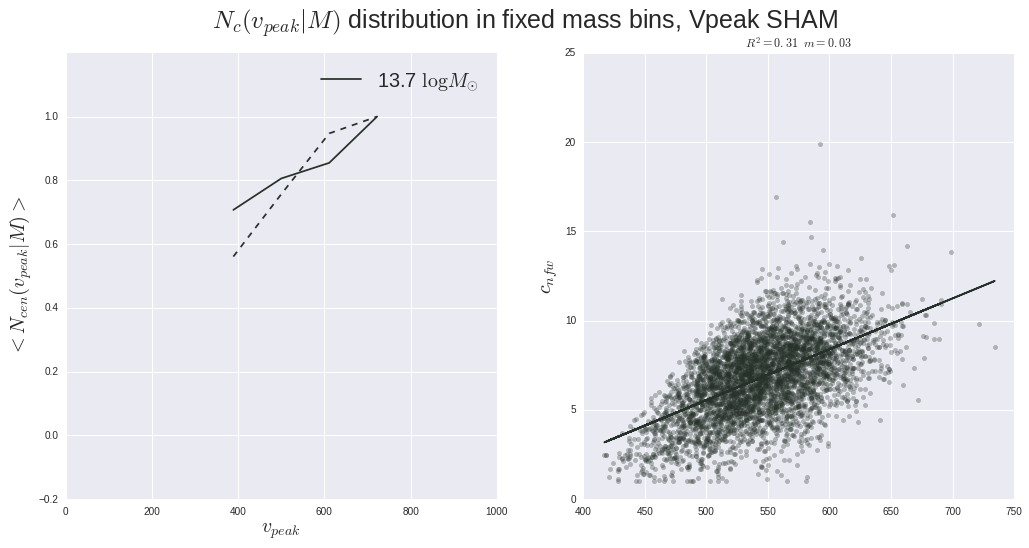

2312.0 1288.0 0.893008883739


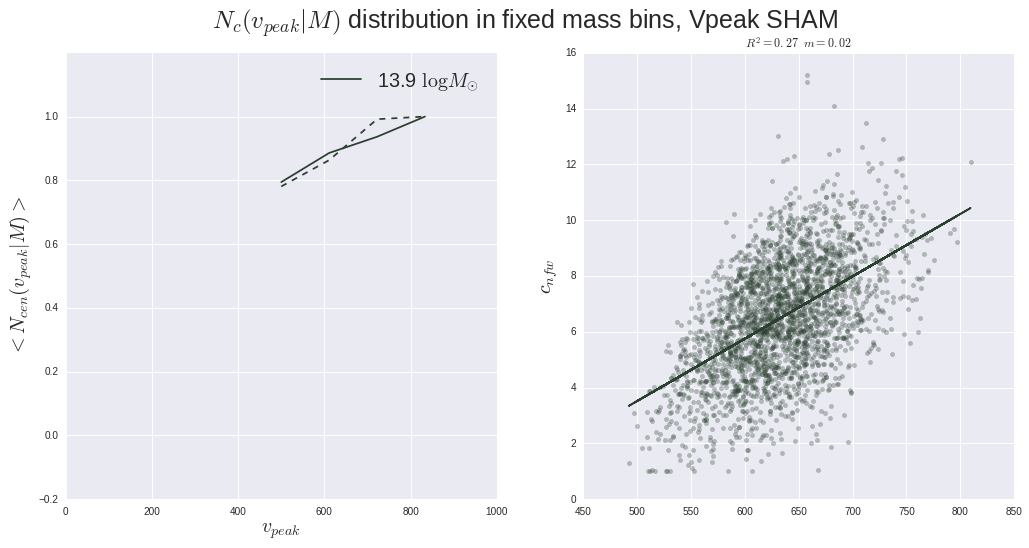

1435.0 1336.0 0.929404145078


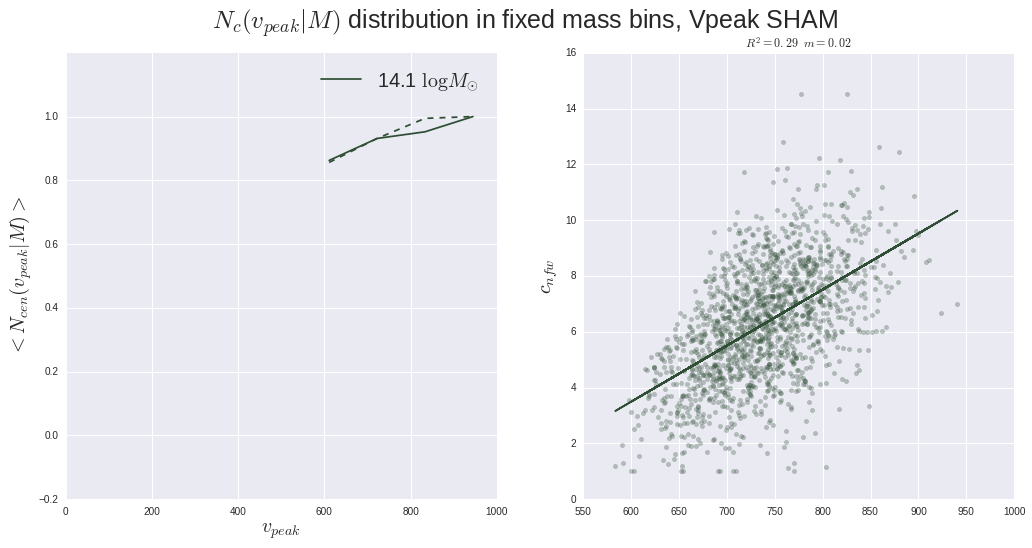

In [19]:
mass_bin_nos = range(1,15,1)
color_idx=0
for bin_no, (hod_cbc, hod_occ) in zip(mass_bin_nos, hod_data):
    #if bin_no < 2 or bin_no >15:
    #    continue
    fig = plt.figure(figsize = ((17,8)))

    c = colors[color_idx]
    color_idx+=1
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])
    
    print np.sum(catalog[indices_of_mb,1]),np.sum(catalog[indices_of_mb,2]), cens_avg
        
    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
    
    cen_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,1], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    #plt.plot(c_bin_centers,(binned_cens-cens_avg),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)
    plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(hod_cbc,hod_occ,color = c,ls = '--')
    #plt.plot(c_bin_centers, np.ones_like(c_bin_centers)*cens_avg, color = 'k')

    #plt.vlines(med_conc, -1, 1, color = c)
    plt.subplot(122)

    #plt.hist(catalog[indices_of_mb, 5], bins = 10, color = c)
    slope, intercept, rvalue, pvalue, stderr = linregress(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_vpeak'],\
                                                          halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'])
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_vpeak'],\
                halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'],\
                color = c, alpha = 0.3)
    plt.plot(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_vpeak'],\
             slope*halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_vpeak']+intercept, color =c )
    plt.title(r'$R^2 = %.2f   \;\; m = %.2f$'%(rvalue**2, slope))
    
    plt.subplot(121)
    #plt.subplot(121)
    #plt.xscale('log')
    #plt.title(r"$N(c)-\langle N \rangle$, centrals")
    plt.legend(loc='best', fontsize=20)
    #plt.xlim([0,25])
    #plt.ylim([-0.5,1.0])
    #plt.subplot(122)
    #plt.title(r"$N(c)$, centrals")
    #plt.yscale('log')
    #plt.xscale('log')
    plt.ylim([-0.2,1.2])
    plt.xlim([0,1000])
    plt.xlabel(r'$v_{peak}$',fontsize=20)
    plt.ylabel(r'$<N_{cen}(v_{peak}|M)>$',fontsize=20)

    plt.suptitle(r"$N_c(v_{peak}|M)$ distribution in fixed mass bins, Vpeak SHAM", fontsize=25)
    plt.subplot(122)
    #plt.xlim([0,1000])
    #plt.xlabel(r'$v_{peak}$',fontsize=20)
    plt.ylabel(r'$c_{nfw}$',fontsize=20)

    plt.show()

In [20]:
hod_catalog= np.loadtxt('hod_catalog.npy')

In [34]:
hod_catalog.shape

(1628416, 6)

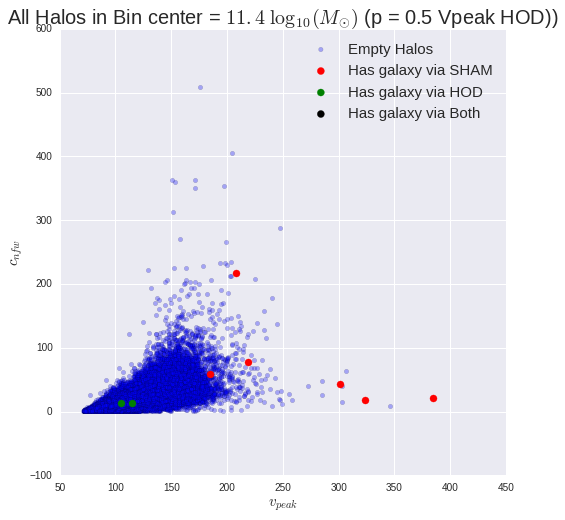

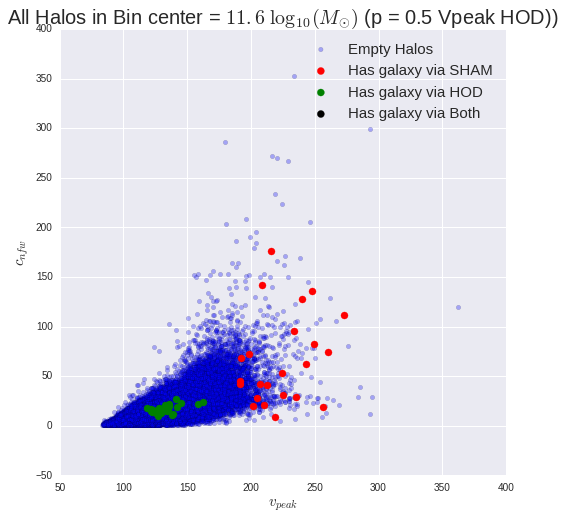

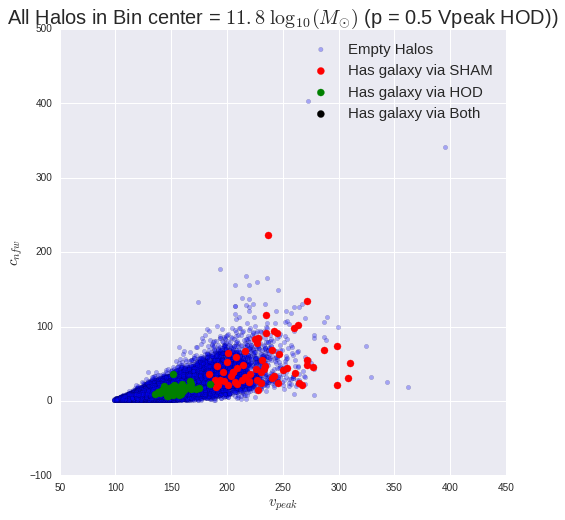

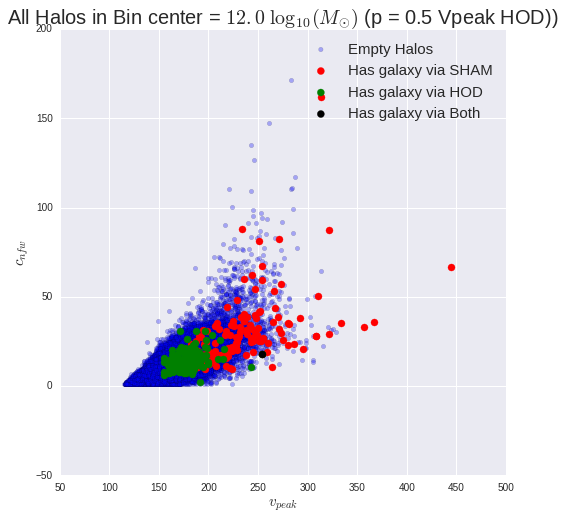

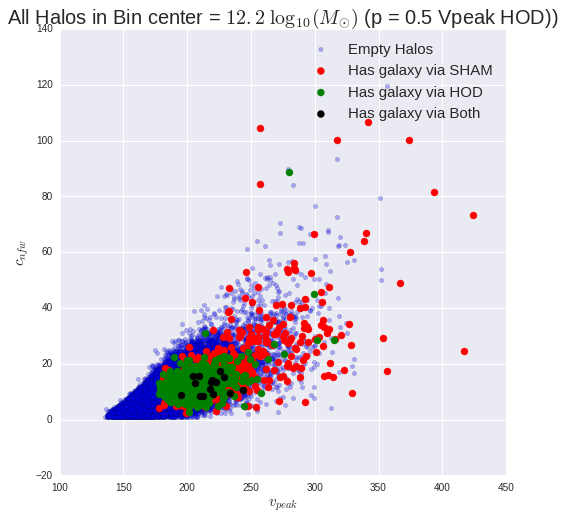

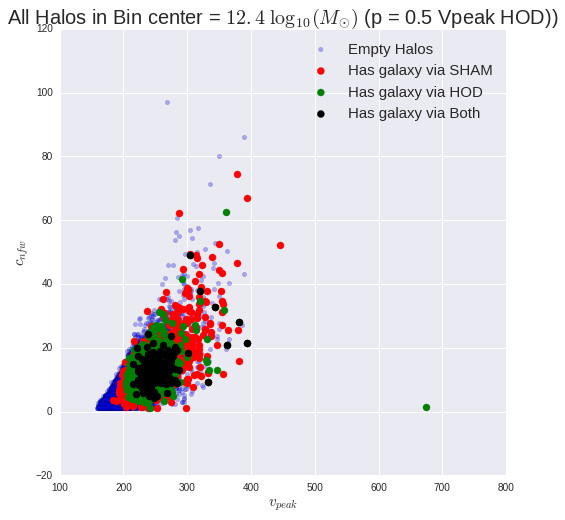

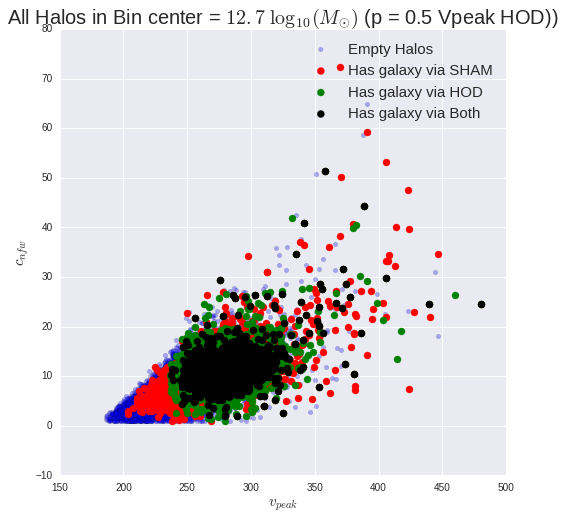

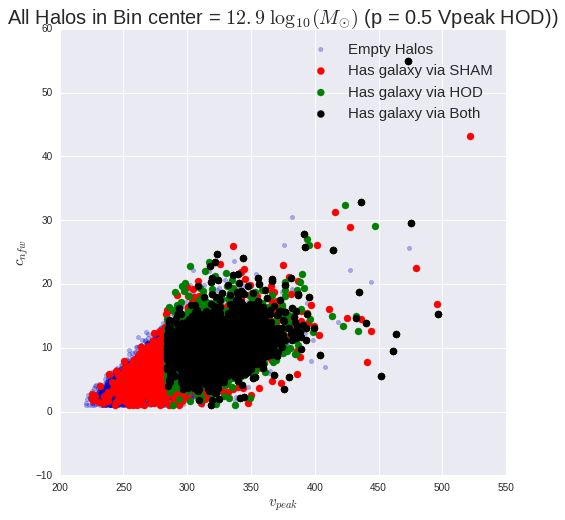

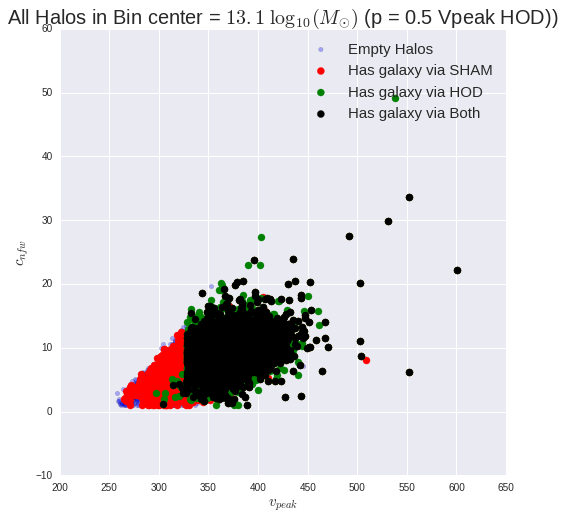

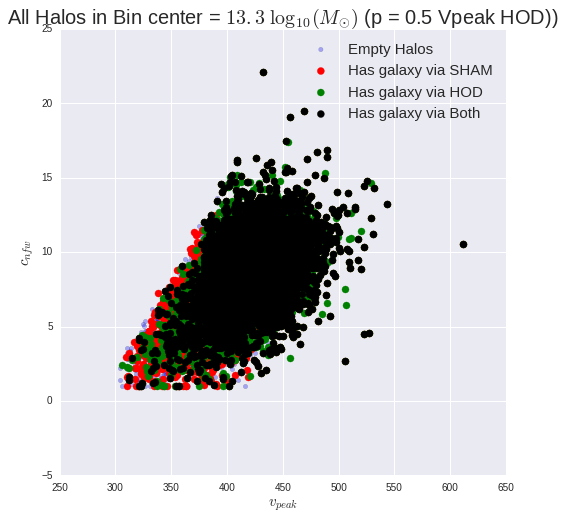

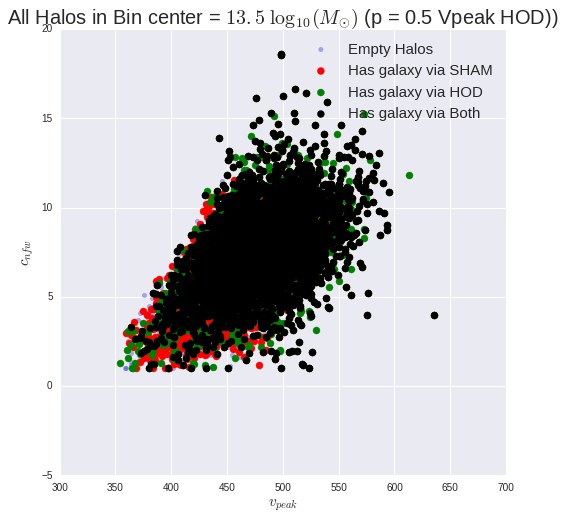

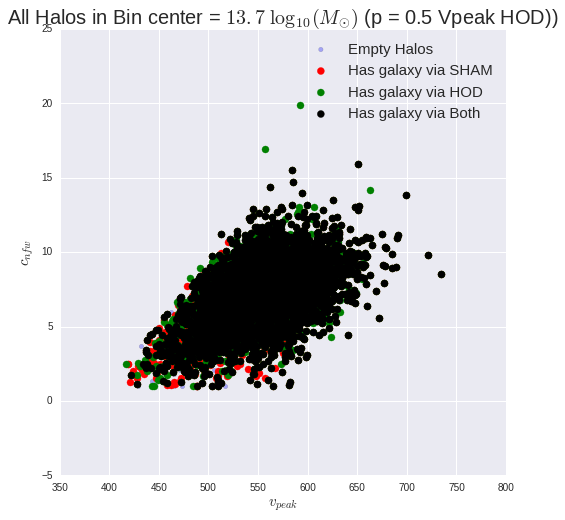

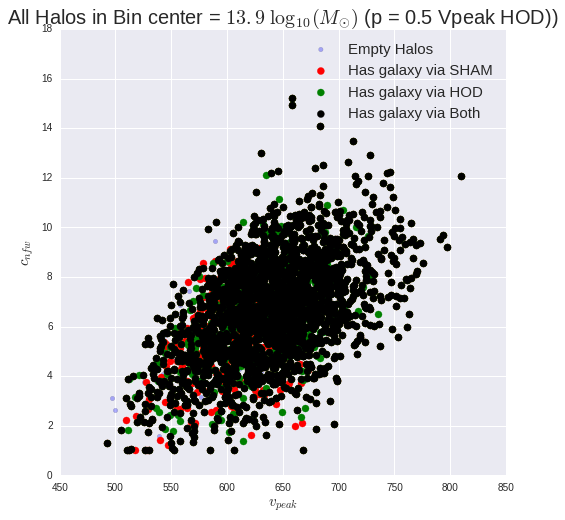

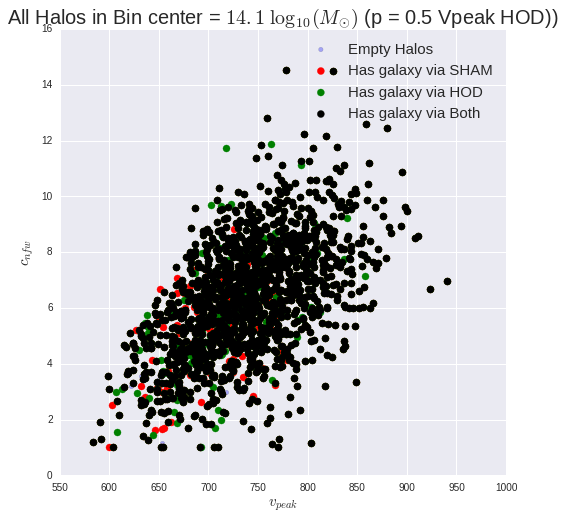

In [21]:
for bin_no, (hod_cbc, hod_occ) in zip(mass_bin_nos, hod_data):
    #if bin_no < 2 or bin_no >15:
    #    continue
    fig = plt.figure(figsize = ((8,8)))

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'],\
                    alpha = 0.3, label = 'Empty Halos')
    
    in_sham = np.where(catalog[indices_of_mb, 1]==1)[0]
    in_hod = np.where(hod_catalog[indices_of_mb, 1]==1)[0]
    
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_sham]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_sham]['halo_nfw_conc'],\
                    color = 'r',s=50, label = 'Has galaxy via SHAM')
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_hod]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_hod]['halo_nfw_conc'],\
                    color = 'g',s=50, label = 'Has galaxy via HOD')
    in_both = np.intersect1d(in_sham, in_hod)
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_both]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_both]['halo_nfw_conc'],\
                    color = 'k',s=50, label = 'Has galaxy via Both')
    
    plt.title(r'All Halos in Bin center = $%.1f\; \log_{10}({M_{\odot}})$ (p = 0.5 Vpeak HOD))'%np.log10(bin_center), fontsize = 20)
    
    plt.xlabel(r"$v_{peak}$", fontsize = 15)
    plt.ylabel(r"$c_{nfw}$", fontsize = 15)
    plt.legend(loc='best', fontsize = 15)

    plt.show()

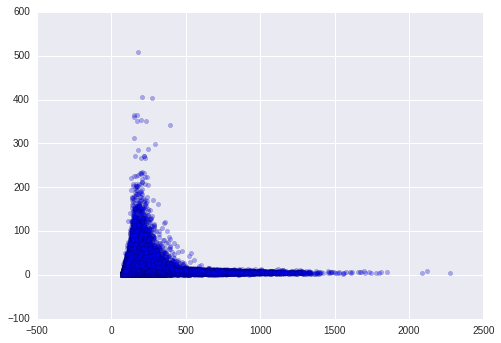

In [22]:
plt.scatter(halo_table[halo_table['halo_upid']==-1]['halo_vpeak'],halo_table[halo_table['halo_upid']==-1]['halo_nfw_conc'],\
           alpha = 0.3)

In [23]:
occupation_ids = []
for bin_no in mass_bin_nos:
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_idxs = np.where(catalog[indices_of_mb,1] == 1)[0]
    occupation_ids.append(set(halo_table[cens_idxs]['halo_id']))

In [24]:
with open('hod_cens_occ_id.pkl', 'r') as f:
    hod_occupation_ids = pickle.load(f)

In [25]:
for bin_no, (hod_occ, sham_occ) in enumerate(zip(hod_occupation_ids, occupation_ids)):
    if bin_no < 4 or bin_no >8:
        continue
    print len(hod_occ), len(sham_occ), len(hod_occ&sham_occ)

747 776 6
3029 3077 113
6591 6613 853
8588 8703 2326
8766 8823 3756


In [26]:
colors = cycle(sns.color_palette())

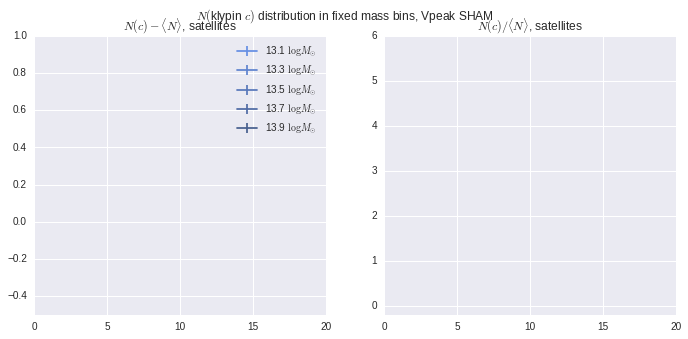

In [27]:
mass_bin_nos = range(9,14,1)
fig = plt.figure(figsize = ((11.5,5)))
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])
    
    med_conc = np.median(klypin_conc[indices_of_mb])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(klypin_conc[indices_of_mb], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(klypin_conc[indices_of_mb], catalog[indices_of_mb, 2], bins = conc_bins)
        
    sat_bin_counts, _, _ = binned_statistic(klypin_conc[indices_of_mb],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.legend(loc='best')
plt.xlim([0,20])
plt.ylim([-0.5,1.0])
plt.subplot(122)
plt.title(r"$N(c)/\langle N \rangle$, satellites")
#plt.yscale('log')
#plt.xscale('log')
plt.ylim([-0.2,6])
plt.xlim([0,20])
plt.suptitle(r"$N($klypin $c)$ distribution in fixed mass bins, Vpeak SHAM")
plt.show()

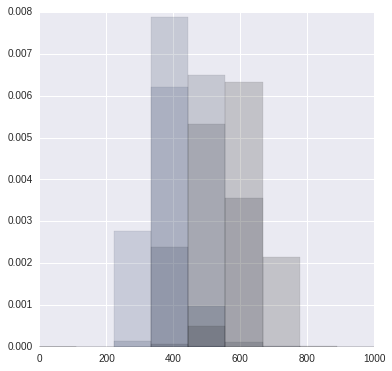

In [28]:
mass_bin_nos = range(9,14,1)
fig = plt.figure(figsize = ((6,6)))
for bin_no, c in zip(mass_bin_nos, colors):
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    
    plt.hist(catalog[indices_of_mb, 5], color = c, alpha = 0.2, bins = c_bins, normed=True)
    
plt.show()

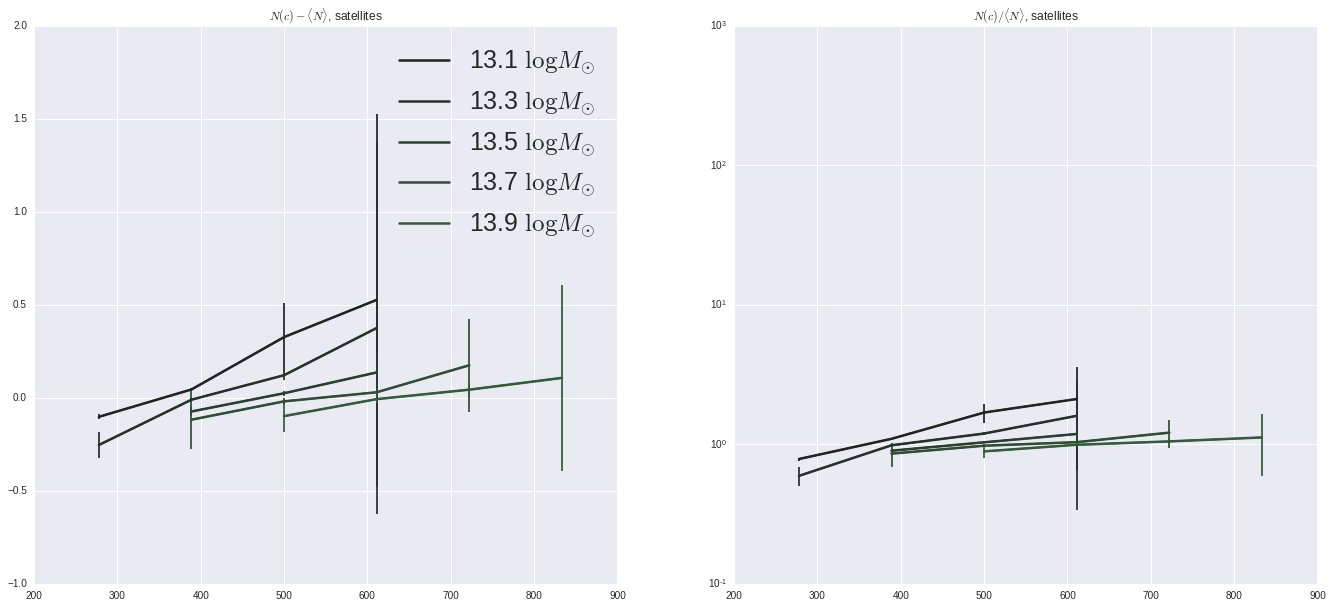

In [29]:
mass_bin_nos = range(9,14,1)
fig = plt.figure(figsize = ((23,10)))
for bin_no, c in zip(mass_bin_nos, colors):

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
        
    cen_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,1], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/20] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    plt.subplot(121)
    plt.plot(c_bin_centers,(binned_cens-cens_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    plt.errorbar(c_bin_centers,(binned_cens-cens_avg), yerr=np.sqrt(binned_cens/cen_bin_counts),color = c)
    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    plt.subplot(122)
    plt.plot(c_bin_centers,binned_cens/cens_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    plt.errorbar(c_bin_centers,(binned_cens/cens_avg), yerr=np.sqrt(binned_cens/(cens_avg*cen_bin_counts)),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.legend(loc='best', fontsize = 25)
plt.subplot(122)
plt.title(r"$N(c)/\langle N \rangle$, satellites")
plt.yscale('log')
#plt.xscale('log')
plt.ylim([1e-1,1e3])
plt.show()

Bin:  [  1.31408522e+12   2.12790035e+12]


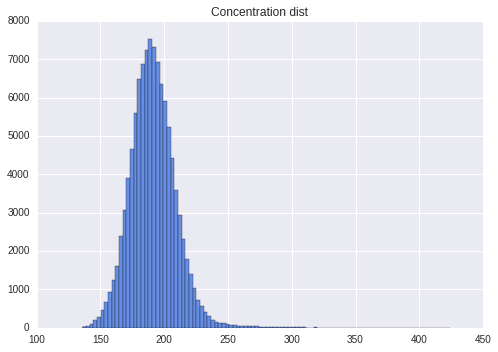

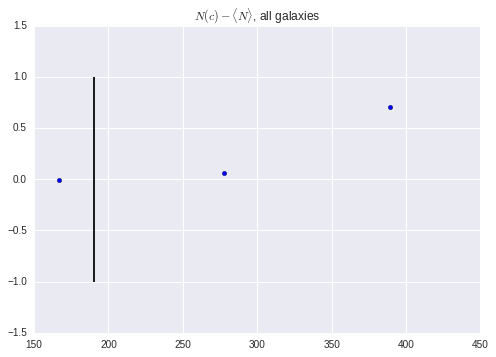

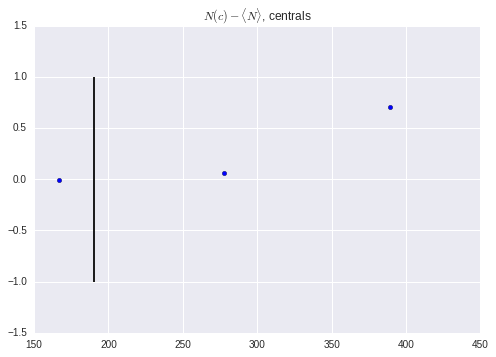

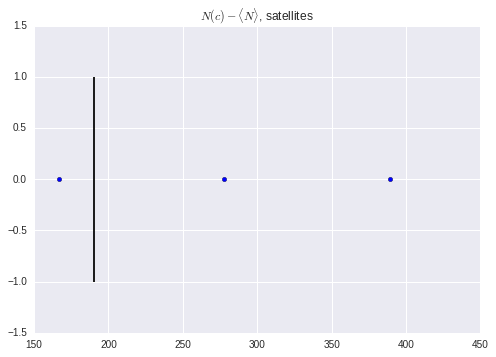

In [30]:
mass_bin_no = 5
print 'Bin: ', mass_bins[mass_bin_no:mass_bin_no+2]
indices_of_mb = np.where(mass_bin_idxs == mass_bin_no)[0]

plt.hist(catalog[indices_of_mb, 5], bins = 100);
plt.title('Concentration dist')
plt.show()

cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

med_conc = np.median(catalog[indices_of_mb, 5])

(binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                           binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
    
c_bin_centers = (c_bins[1:]+c_bins[:-1])/2

plt.scatter(c_bin_centers,binned_cens+ binned_sats-cens_avg-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, all galaxies")
plt.vlines(med_conc, -1, 1)
plt.show()

plt.scatter(c_bin_centers,binned_cens-cens_avg)
plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_sats-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.vlines(med_conc, -1, 1)

plt.show()

Bin:  [  9.03513313e+12   1.46306059e+13]


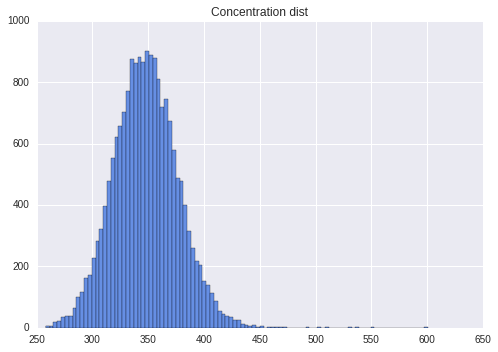

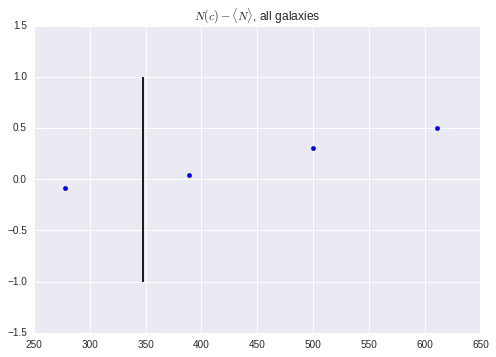

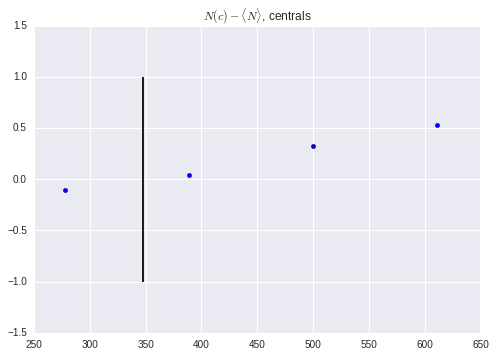

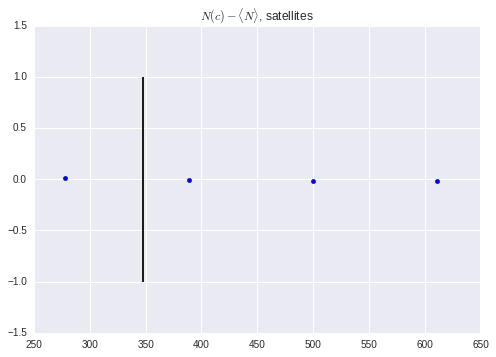

In [31]:
mass_bin_no = 9
print 'Bin: ', mass_bins[mass_bin_no:mass_bin_no+2]
indices_of_mb = np.where(mass_bin_idxs == mass_bin_no)[0]

plt.hist(catalog[indices_of_mb, 5], bins = 100);
plt.title('Concentration dist')
plt.show()

cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

med_conc = np.median(catalog[indices_of_mb, 5])

(binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                           binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
    
c_bin_centers = (c_bins[1:]+c_bins[:-1])/2

plt.scatter(c_bin_centers,binned_cens+binned_sats-cens_avg-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, all galaxies")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_cens-cens_avg)
plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_sats-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.vlines(med_conc, -1, 1)

plt.show()

Bin:  [  6.21220220e+13   1.00594292e+14]


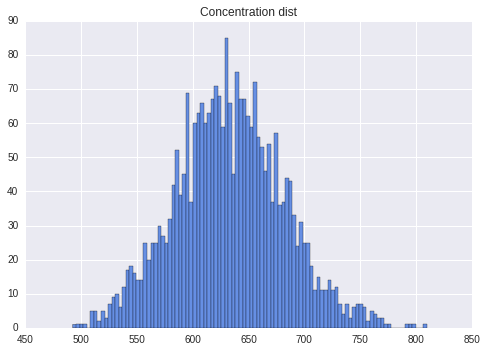

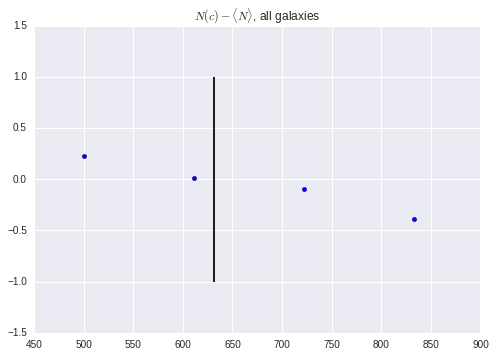

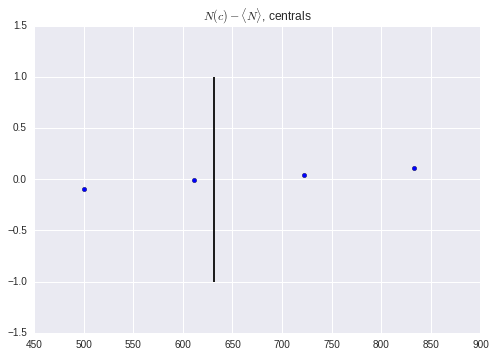

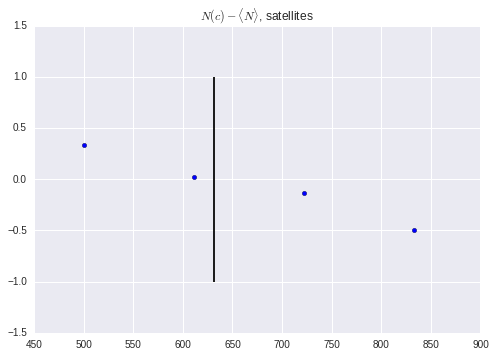

In [32]:
mass_bin_no = 13
print 'Bin: ', mass_bins[mass_bin_no:mass_bin_no+2]
indices_of_mb = np.where(mass_bin_idxs == mass_bin_no)[0]

plt.hist(catalog[indices_of_mb, 5], bins = 100);
plt.title('Concentration dist')
plt.show()

cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])

med_conc = np.median(catalog[indices_of_mb, 5])

(binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                           binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)
    
c_bin_centers = (c_bins[1:]+c_bins[:-1])/2

plt.scatter(c_bin_centers,binned_cens+binned_sats-cens_avg-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, all galaxies")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_cens-cens_avg)
plt.title(r"$N(c)-\langle N \rangle$, centrals")
plt.vlines(med_conc, -1, 1)

plt.show()

plt.scatter(c_bin_centers,binned_sats-sats_avg)
plt.title(r"$N(c)-\langle N \rangle$, satellites")
plt.vlines(med_conc, -1, 1)

plt.show()